#Import

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

import os
import random
import collections
from collections import defaultdict

import shutil
from shutil import copy
from shutil import copytree, rmtree

import numpy as np
from google.colab import files

import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.image as mpimg
%matplotlib inline

#Download Datasets

In [ ]:
def get_dataset_and_extract():
  if "UECFOOD100" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
      'dataset100.zip',
      'http://foodcam.mobi/dataset100.zip',
      cache_subdir='/content',
      extract=True,
      archive_format='zip',
      cache_dir=None
    )

In [ ]:
get_dataset_and_extract()

991371264/991355222 [==============================] - 57s 0us/step


# Inspect the Dataset Structure

##Folder Structure and Files

In [ ]:
main_path = 'UECFOOD100/'

In [ ]:
os.listdir(main_path)

['70',
 'category_ja_sjis.txt',
 'README.txt',
 '51',
 '57',
 '94',
 '95',
 '79',
 '88',
 '67',
 '60',
 '61',
 '28',
 '24',
 '19',
 '64',
 '18',
 '48',
 '54',
 '46',
 '96',
 '3',
 '53',
 '33',
 '93',
 '8',
 '83',
 'category_ja_utf8.txt',
 '20',
 '31',
 '62',
 '80',
 '59',
 '86',
 '58',
 '85',
 '22',
 '52',
 '63',
 '37',
 '38',
 '47',
 '98',
 '45',
 '36',
 '65',
 '5',
 '21',
 '9',
 '91',
 '6',
 '16',
 '42',
 '56',
 '27',
 '17',
 '99',
 '78',
 '84',
 '89',
 '97',
 '68',
 '76',
 '72',
 '1',
 '23',
 '69',
 '81',
 '74',
 '25',
 '12',
 'category.txt',
 '50',
 '13',
 '7',
 '73',
 '90',
 '29',
 '15',
 '39',
 '26',
 '66',
 '30',
 '100',
 '35',
 '71',
 '87',
 '4',
 '44',
 '2',
 'category_ja_euc.txt',
 '40',
 '77',
 '32',
 '10',
 '49',
 '55',
 '14',
 '41',
 '75',
 '43',
 '34',
 'multiple_food.txt',
 '11',
 '92',
 '82']

In [ ]:
# make food categories based on category.txt
category_file = main_path + 'category.txt'

origin_folders = []
categories = {}
with open(category_file, 'r') as txt:
  for read in txt.readlines()[1:]:
    category_id = read.split('\t')[0]
    category_name = read.split('\t')[1].split('\n')[0].strip()
    categories[category_id] = category_name.lower().replace(' ', '_')

    origin_folders.append(category_id)

categories['4'] = 'chicken and egg on rice'
print(categories)

{'1': 'rice', '2': 'eels_on_rice', '3': 'pilaf', '4': 'chicken and egg on rice', '5': 'pork_cutlet_on_rice', '6': 'beef_curry', '7': 'sushi', '8': 'chicken_rice', '9': 'fried_rice', '10': 'tempura_bowl', '11': 'bibimbap', '12': 'toast', '13': 'croissant', '14': 'roll_bread', '15': 'raisin_bread', '16': 'chip_butty', '17': 'hamburger', '18': 'pizza', '19': 'sandwiches', '20': 'udon_noodle', '21': 'tempura_udon', '22': 'soba_noodle', '23': 'ramen_noodle', '24': 'beef_noodle', '25': 'tensin_noodle', '26': 'fried_noodle', '27': 'spaghetti', '28': 'japanese-style_pancake', '29': 'takoyaki', '30': 'gratin', '31': 'sauteed_vegetables', '32': 'croquette', '33': 'grilled_eggplant', '34': 'sauteed_spinach', '35': 'vegetable_tempura', '36': 'miso_soup', '37': 'potage', '38': 'sausage', '39': 'oden', '40': 'omelet', '41': 'ganmodoki', '42': 'jiaozi', '43': 'stew', '44': 'teriyaki_grilled_fish', '45': 'fried_fish', '46': 'grilled_salmon', '47': 'salmon_meuniere', '48': 'sashimi', '49': 'grilled_pac

In [ ]:
# make labels
labels_temp = list(categories.values())
labels_temp.sort()

labels = []
for label in labels_temp:
  new_label = label.replace("_", " ")
  labels.append(new_label)
labels.sort()

labels

['beef bowl',
 'beef curry',
 'beef noodle',
 'beef steak',
 'bibimbap',
 'boiled chicken and vegetables',
 'boiled fish',
 'cabbage roll',
 'chicken and egg on rice',
 'chicken rice',
 'chilled noodle',
 'chinese soup',
 'chip butty',
 'cold tofu',
 'croissant',
 'croquette',
 'cutlet curry',
 'dipping noodles',
 'dried fish',
 'eels on rice',
 'egg roll',
 'egg sunny-side up',
 'fermented soybeans',
 'fish-shaped pancake with bean jam',
 'french fries',
 'fried chicken',
 'fried fish',
 'fried noodle',
 'fried rice',
 'fried shrimp',
 'ganmodoki',
 'ginger pork saute',
 'goya chanpuru',
 'gratin',
 'green salad',
 'grilled eggplant',
 'grilled pacific saury',
 'grilled salmon',
 'hambarg steak',
 'hamburger',
 'hot dog',
 'japanese tofu and vegetable chowder',
 'japanese-style pancake',
 'jiaozi',
 'kinpira-style sauteed burdock',
 'lightly roasted fish',
 'macaroni salad',
 'miso soup',
 'mixed rice',
 'nanbanzuke',
 'oden',
 'omelet',
 'omelet with fried rice',
 'pilaf',
 'pizza',


In [ ]:
# check labels number
len(labels)

100

##Visualize image

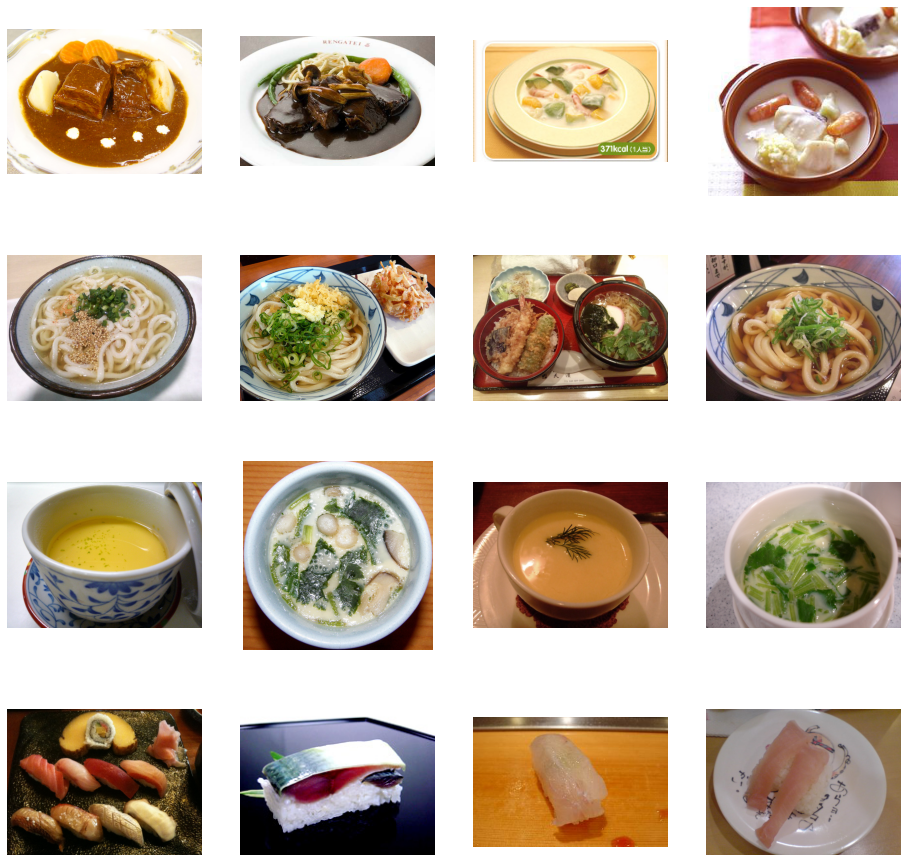

In [ ]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

rdm_classes = random.sample(origin_folders, len(origin_folders))[:4]     

pic_index+=4

rdm_classes_img = []
for class_item in rdm_classes: 
  class_img = [os.path.join(main_path+class_item, fname) 
                      for fname in os.listdir(main_path+class_item)[pic_index-4:pic_index]
                    ]
  rdm_classes_img.extend(class_img)

for i, img_path in enumerate(rdm_classes_img):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

#Split the image data into train and validation using train.txt and test.txt

In [ ]:
def split_dataset(main_path, origin_folders, categories, train_dir, validation_dir, train_pc):
  if not os.path.exists(main_path + 'datasets'):
    os.mkdir(main_path + 'datasets')
    os.mkdir(main_path + 'datasets/train')
    os.mkdir(main_path + 'datasets/validation')

  for folder_parent in origin_folders:
    image_files = os.listdir(main_path+folder_parent)
    image_files.sort()
    random.shuffle(image_files)

    images_number = len(image_files)
    train_number = images_number*train_pc
    
    train_images = image_files[:int(train_number)]
    validation_images = image_files[int(train_number):]

    # split dataset to train
    food_class = categories[folder_parent]
    if not os.path.exists(main_path + 'datasets/train/' +  food_class):
      os.mkdir(main_path + 'datasets/train/' +  food_class)

      for image_name in train_images:
        if image_name != 'bb_info.txt':
          copy(main_path + folder_parent + '/' + image_name, main_path + 'datasets/train/' +  food_class + "/" + image_name)

    # split dataset to validation
    if not os.path.exists(main_path + 'datasets/validation/' +  food_class):
      os.mkdir(main_path + 'datasets/validation/' +  food_class)

      for image_name in validation_images:
        if image_name != 'bb_info.txt':
          copy(main_path + folder_parent + '/' + image_name, main_path + 'datasets/validation/' +  food_class + "/" + image_name)

In [ ]:
train_pc = 0.7
train_dir = main_path+'datasets/train'
validation_dir = main_path+'datasets/validation'

In [ ]:
# Prepare dataset
split_dataset(main_path, origin_folders, categories, train_dir, validation_dir, train_pc)

In [ ]:
# Check how many files are in the train folder
train_files = sum([len(files) for i, j, files in os.walk(train_dir)])
print("Total number of files in train folder")
print(train_files)

Total number of files in train folder
10005


In [ ]:
# Check how many files are in the test folder
validation_files = sum([len(files) for i, j, files in os.walk(validation_dir)])
print("Total number of files in validation folder")
print(validation_files)

Total number of files in validation folder
4356


#Training and Validation Generators

In [ ]:
def train_val_generator(train_dir, validation_dir, batch_size, img_width, img_height):
  train_datagen = ImageDataGenerator(
      rescale = 1./255.,
      rotation_range = 40,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip = True,
      fill_mode='nearest')

  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size
  )

  validation_generator = validation_datagen.flow_from_directory(
      validation_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')
  
  return train_generator, validation_generator

In [ ]:
batch_size = 64
img_width = 256
img_height = 256

In [ ]:
train_generator, validation_generator = train_val_generator(train_dir, validation_dir, batch_size, img_width, img_height)

Found 10005 images belonging to 100 classes.
Found 4356 images belonging to 100 classes.


#Create Model

In [ ]:
def create_pre_trained_model(img_width, img_height):
  pre_trained_model = InceptionV3(input_shape = (img_width, img_height, 3),
                                  include_top = False, 
                                  weights = 'imagenet') 

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [ ]:
pre_trained_model = create_pre_trained_model(img_width, img_height)

# Print the model summary
pre_trained_model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [ ]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('mixed10')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 6, 6, 2048)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 2048), dtype=tf.float32, name=None), name='mixed10/concat:0', description="created by layer 'mixed10'")


In [ ]:
num_classes = len(labels)
num_classes

100

In [ ]:
def create_model(pre_trained_model, last_output, num_classes):
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  # Add a fully connected layer with 512 hidden units and ReLU activation
  x = layers.Dense(512, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)  
  # Add a final softmax layer for classification
  x = layers.Dense(num_classes, activation='softmax')(x)        

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = SGD(learning_rate=0.0001), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model

In [ ]:
# Save your model in a variable
model = create_model(pre_trained_model, last_output, num_classes)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 59,603,332 total parameters in this model.
There are 37,800,548 trainable parameters in this model.


#Train Model

In [ ]:
num_epochs = 100

In [ ]:
def train_model(num_epochs, train_files, validation_files, batch_size):
  checkpoint_path = "training_1/cp.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)

  # Create a callback that saves the model's weights
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)

  history = model.fit(train_generator,
                      steps_per_epoch = train_files // batch_size,
                      validation_data=validation_generator,
                      validation_steps = validation_files // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[cp_callback])
  return history

In [ ]:
history = train_model(num_epochs, train_files, validation_files, batch_size)

Epoch 1/100
150/150 [==============================] - ETA: 0s - loss: 1.0011 - accuracy: 0.5342
Epoch 1: saving model to training_1/cp.ckpt
150/150 [==============================] - 72s 391ms/step - loss: 1.0011 - accuracy: 0.5342 - val_loss: 0.8278 - val_accuracy: 0.8240
Epoch 2/100
150/150 [==============================] - ETA: 0s - loss: 0.8144 - accuracy: 0.7436
Epoch 2: saving model to training_1/cp.ckpt
150/150 [==============================] - 59s 396ms/step - loss: 0.8144 - accuracy: 0.7436 - val_loss: 0.6237 - val_accuracy: 0.9120
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 0.6696 - accuracy: 0.8200
Epoch 3: saving model to training_1/cp.ckpt
150/150 [==============================] - 58s 386ms/step - loss: 0.6696 - accuracy: 0.8200 - val_loss: 0.4796 - val_accuracy: 0.9400
Epoch 4/100
150/150 [==============================] - ETA: 0s - loss: 0.5737 - accuracy: 0.8636
Epoch 4: saving model to training_1/cp.ckpt
150/150 [=========================

#Visualize the accuracy and loss plots

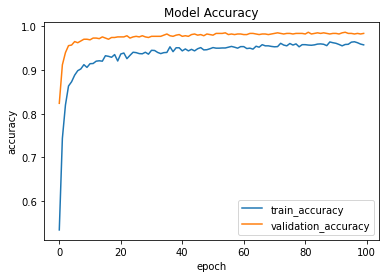

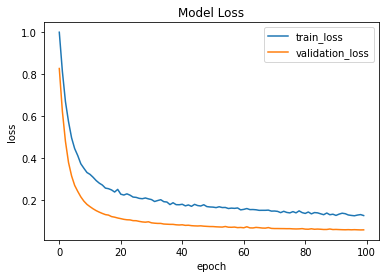

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'Model Accuracy')
plot_loss(history,'Model Loss')

#Predicting

In [64]:
!gdown --id 1pup5aQHZiEKKY_HVk_TmYytUAcMIfucX

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1pup5aQHZiEKKY_HVk_TmYytUAcMIfucX
To: /content/image_testing.zip
100% 475k/475k [00:00<00:00, 145MB/s]


In [65]:
if not os.path.exists('image_testing'):
  shutil.unpack_archive('image_testing.zip', './')

In [70]:
def predict_class(model, images, food_names = ''):
  i = 0
  for img in images:
    img = image.load_img(img, target_size=(img_width, img_height))
    x = image.img_to_array(img)                    
    x = np.expand_dims(img, axis=0)

    images = np.vstack([x])
    images = images / 255.                                   

    pred = model.predict(images)
    index = np.argmax(pred)
    pred_value = labels[index]
    # print(pred)

    if food_names != '':
      print('Food Name: [{}]'.format(food_names[i]))
      i += 1

    plt.imshow(img)                           
    plt.axis('off')
    plt.title('Pred: ' + pred_value)
    plt.show()

In [71]:
image_path = 'image_testing/'

Food Name: [fried_rice.jpg]


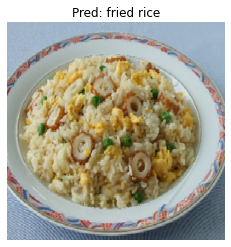

Food Name: [hamburger.jpg]


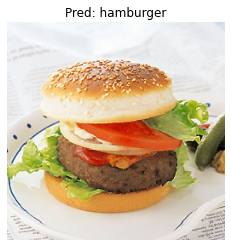

Food Name: [omelet.jpg]


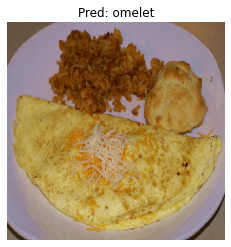

Food Name: [fried_chicken.jpg]


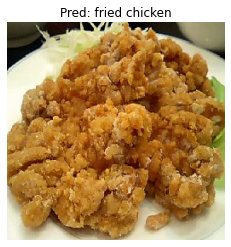

Food Name: [spaghetti.jpg]


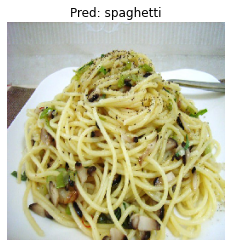

Food Name: [sushi.jpg]


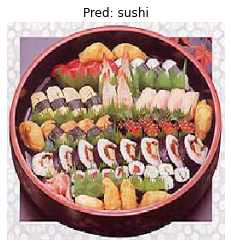

Food Name: [sandwiches.jpg]


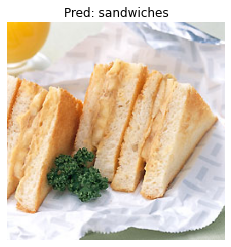

Food Name: [ramen_noodle.jpg]


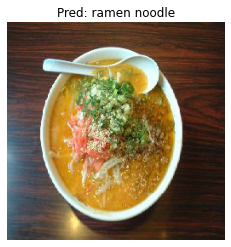

Food Name: [hambarg_steak.jpg]


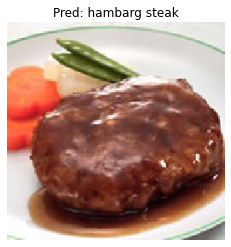

Food Name: [pizza.jpg]


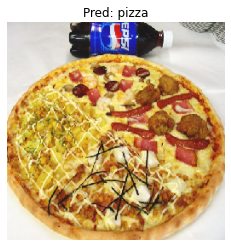

In [72]:
# Predicting with prepared images
images = []
food_names = []

for img_test in os.listdir(image_path):
  images.append(image_path + img_test)
  food_names.append(img_test)

predict_class(model, images, food_names)

Saving download.jpg to download.jpg
download.jpg


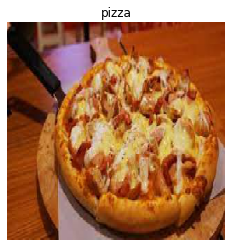

In [73]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(img_width, img_height))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  images = images / 255.
  classes_pred = model.predict(images, batch_size=10)
  index = np.argmax(classes_pred)
  pred_value = labels[index]
  print(fn)
  # print(classes_pred)

  plt.imshow(img)                           
  plt.axis('off')
  plt.title(pred_value)
  plt.show()

#Export the Model

In [82]:
# Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = 'saved_model/1'

In [83]:
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1/assets


In [84]:
%%bash -s $export_dir
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 256, 256, 3)
      name: serving_default_input_1:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_5'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 100)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [85]:
loaded = tf.saved_model.load(export_dir)

In [86]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'input_1': TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1')})
{'dense_5': TensorSpec(shape=(None, 100), dtype=tf.float32, name='dense_5')}


#save model to TFlite

In [ ]:
# Select mode of optimization
mode = None

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
# Use the TFLiteConverter SavedModel API to initialize the converter
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

# Test the TFLite Model Using the Python Interpreter

In [75]:
# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [78]:
def predict_tflite(images, food_names):
  i = 0
  for img_path in images:
    img = image.load_img(img_path, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    images = images / 255.                             

    interpreter.set_tensor(input_index, images)
    interpreter.invoke()
    pred = interpreter.get_tensor(output_index)

    index = np.argmax(pred)
    pred_value = labels[index]
    # print(pred)

    if food_names != '':
      print("Food names = [{}]".format(food_names[i]))
      i += 1

    plt.imshow(img)                           
    plt.axis('off')
    plt.title("Pred: " + pred_value)
    plt.show()

Food names = [fried_rice.jpg]


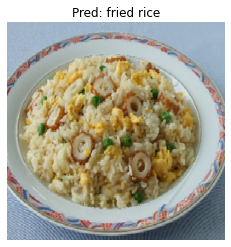

Food names = [hamburger.jpg]


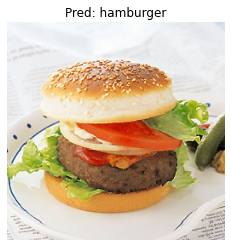

Food names = [omelet.jpg]


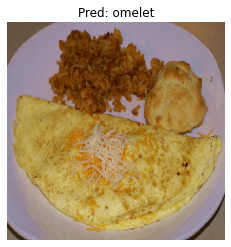

Food names = [fried_chicken.jpg]


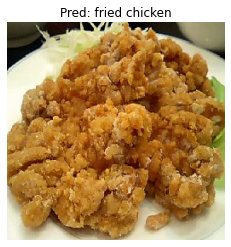

Food names = [spaghetti.jpg]


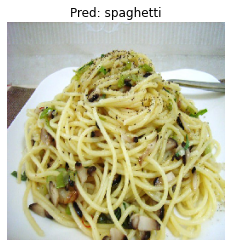

Food names = [sushi.jpg]


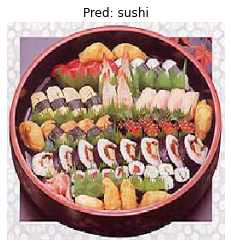

Food names = [sandwiches.jpg]


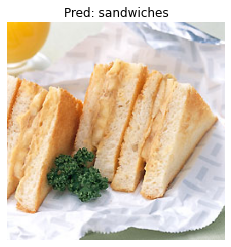

Food names = [ramen_noodle.jpg]


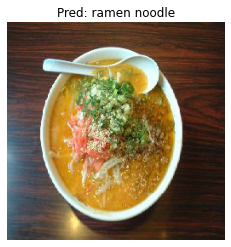

Food names = [hambarg_steak.jpg]


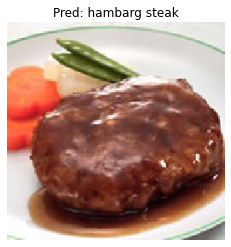

Food names = [pizza.jpg]


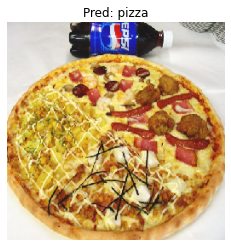

In [79]:
# Predicting with prepared images
images = []
food_names = []

for img_test in os.listdir(image_path):
  images.append(image_path + img_test)
  food_names.append(img_test)

predict_tflite(images, food_names)

#Download Save Model and TF Lite

In [80]:
# make label.txt
textfile = open("labels.txt", "w")
for element in labels:
    textfile.write(element + "\n")
textfile.close()

In [81]:
# print label.txt
labels_files = 'labels.txt'

label_items = []
with open(labels_files, 'r') as txt:
    label_items = [read.strip() for read in txt.readlines()]

label_items

['beef bowl',
 'beef curry',
 'beef noodle',
 'beef steak',
 'bibimbap',
 'boiled chicken and vegetables',
 'boiled fish',
 'cabbage roll',
 'chicken and egg on rice',
 'chicken rice',
 'chilled noodle',
 'chinese soup',
 'chip butty',
 'cold tofu',
 'croissant',
 'croquette',
 'cutlet curry',
 'dipping noodles',
 'dried fish',
 'eels on rice',
 'egg roll',
 'egg sunny-side up',
 'fermented soybeans',
 'fish-shaped pancake with bean jam',
 'french fries',
 'fried chicken',
 'fried fish',
 'fried noodle',
 'fried rice',
 'fried shrimp',
 'ganmodoki',
 'ginger pork saute',
 'goya chanpuru',
 'gratin',
 'green salad',
 'grilled eggplant',
 'grilled pacific saury',
 'grilled salmon',
 'hambarg steak',
 'hamburger',
 'hot dog',
 'japanese tofu and vegetable chowder',
 'japanese-style pancake',
 'jiaozi',
 'kinpira-style sauteed burdock',
 'lightly roasted fish',
 'macaroni salad',
 'miso soup',
 'mixed rice',
 'nanbanzuke',
 'oden',
 'omelet',
 'omelet with fried rice',
 'pilaf',
 'pizza',


In [ ]:
!zip -r saved_model.zip saved_model

  adding: saved_model/ (stored 0%)
  adding: saved_model/1/ (stored 0%)
  adding: saved_model/1/saved_model.pb (deflated 93%)
  adding: saved_model/1/variables/ (stored 0%)
  adding: saved_model/1/variables/variables.index (deflated 78%)
  adding: saved_model/1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model/1/assets/ (stored 0%)


In [ ]:
try:
    files.download('converted_model.tflite')
    files.download('saved_model.zip')
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>